# Preprocessing

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import optuna
import os, sys

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


/home/ubnps23/tecHub/AD_intro/advattacks_iitp_summer/a3_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# changing core directory
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')
%ls

config_examples/  datasets/  notebooks/  README.md  source/


In [9]:
from source.training.early_stopping import EarlyStopping
from source.data.power_cons import load_powercons, PowerConsDataset

# from source.training.activation import Activation

from source.classifiers.LSTM_Classifier import LSTMClassifier
from source.classifiers.ResCNN_Classifier import ResCNNClassifier
from source.classifiers.PatchTST_classifier import PatchTSTClassifier
from source.training.train_classifier import train_classifier

In [21]:
SEED = 1000
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
TRAIN_PATH = Path('datasets/PowerCons_TRAIN.tsv')
TEST_PATH = Path('datasets/PowerCons_TEST.tsv')
BATCH_SIZE = 64

# Dataset preparation

In [12]:
X_train, y_train, classes_ = load_powercons(TRAIN_PATH)
X_test, y_test, _ = load_powercons(TEST_PATH)
n_classes = len(classes_)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape, 'n_classes:', n_classes)

Train shape: (180, 144, 1) Test shape: (180, 144, 1) n_classes: 2


In [13]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())

-1.6031435 6.4025993 -1.6804967 5.9844995


In [14]:
train_ds = PowerConsDataset(X_train, y_train)
test_ds = PowerConsDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

counts:
1    90
2    90
Name: 0, dtype: int64
shares:
1    0.5
2    0.5
Name: 0, dtype: float64


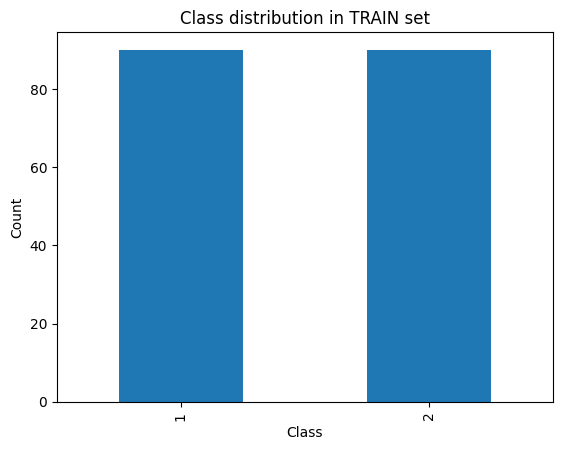

In [ ]:
# check data-balance
df = pd.read_csv(TRAIN_PATH, sep='\t', header=None)

label_counts = df.iloc[:, 0].value_counts().sort_index()
print(f'counts:\n{label_counts}')     
print(f'shares:\n{label_counts / len(df)}')


label_counts.plot.bar()
plt.title('Class distribution in TRAIN set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [16]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g)

# Classifiers

In [17]:
clf_LSTM = LSTMClassifier(n_classes, hidden_size=50, num_layers=1)

history, _, _=  train_classifier(
    clf_LSTM,
    train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=4,
    verbose_every=1
)

Epoch 01: train_loss=0.6967 acc=0.4611 | val_loss=0.6944 acc=0.5000
Epoch 02: train_loss=0.6932 acc=0.5000 | val_loss=0.6917 acc=0.5000
Epoch 03: train_loss=0.6898 acc=0.5000 | val_loss=0.6891 acc=0.5944
Epoch 04: train_loss=0.6868 acc=0.5833 | val_loss=0.6865 acc=0.5833
Epoch 05: train_loss=0.6844 acc=0.5778 | val_loss=0.6841 acc=0.5500
Epoch 06: train_loss=0.6804 acc=0.5944 | val_loss=0.6819 acc=0.5556
Epoch 07: train_loss=0.6775 acc=0.5944 | val_loss=0.6796 acc=0.5611
Epoch 08: train_loss=0.6744 acc=0.6000 | val_loss=0.6768 acc=0.5611
Epoch 09: train_loss=0.6696 acc=0.6000 | val_loss=0.6738 acc=0.5667
Epoch 10: train_loss=0.6644 acc=0.6111 | val_loss=0.6698 acc=0.5778
Epoch 11: train_loss=0.6578 acc=0.6222 | val_loss=0.6640 acc=0.5889
Epoch 12: train_loss=0.6470 acc=0.6444 | val_loss=0.6533 acc=0.6111
Epoch 13: train_loss=0.6277 acc=0.6667 | val_loss=0.6296 acc=0.6556
Epoch 14: train_loss=0.5877 acc=0.6944 | val_loss=0.5663 acc=0.7111
Epoch 15: train_loss=0.4995 acc=0.7500 | val_los

In [18]:
clf_resCNN = ResCNNClassifier(n_classes=n_classes, x_dim=1).to(device)

history, best_val, best_state = train_classifier(
    clf_resCNN,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=10,
    verbose_every=1
)

torch.save(best_state, "rescnn_classifier_best.pth")

Epoch 01: train_loss=0.5020 acc=0.7167 | val_loss=0.4530 acc=0.8556
Epoch 02: train_loss=0.3624 acc=0.8389 | val_loss=0.4647 acc=0.7722


In [19]:
loader = train_dl
x, _ = next(iter(loader))
seq_len = x.size(1)
print("Sequence length =", seq_len)

Sequence length = 144


In [20]:
patch_params = dict(
    seq_len=seq_len,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=40,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

clf_PatchTST = PatchTSTClassifier(
    n_classes=n_classes,
    x_dim=1,
    activation_type="identity",
    patch_kwargs=patch_params
).to(device)

history, best_val, best_wts = train_classifier(
    model=clf_PatchTST,
    train_loader=train_dl,
    val_loader=test_dl,
    epochs=2,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    patience=8,
    verbose_every=2
)

Epoch 02: train_loss=2.6224 acc=0.7778 | val_loss=1.9763 acc=0.8611
Epoch 04: train_loss=0.8798 acc=0.9389 | val_loss=1.0531 acc=0.8944


# Adversarial attacks

In [25]:
LEARNING_TARGET = clf_PatchTST

In [39]:
from source.attacks.iFGSM import FGSMAttack, iFGSMAttack
from source.attacks.PGD import PGDAttack 

from source.attacks.attackLSTM import AttackLSTM
from source.attacks.attackResCNN import AttackCNN
from source.attacks.attackPatchTST import AttackPatchTST 

from source.attacks.mba import ModelBasedAttack 

from source.training.train_attacker import train_atk_model
from source.training.train_iter_attack import train_attack_iter, prepare_victim_for_input_grad

## LSTM attack

In [31]:
atk_LSTM = AttackLSTM(hidden_dim=128, dropout=0.6, x_dim=1, activation_type='tanh').to(device)
for p in clf_LSTM.parameters():
    p.requires_grad_(False)
# clf_LSTM.eval()

eps_LSTM = 1.371353
train_atk_model(atk_LSTM,
                LEARNING_TARGET,
                train_dl,
                eps=eps_LSTM,
                epochs=1,
                lr=1e-1,
                alpha_l2=6e-4,
                device=device,
                patience=9
)


Epoch 01 | victim‑loss 0.5128 | acc 0.9611


(0.512811976008945, 0.9611111124356587)

In [ ]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    atk_model = AttackLSTM(
        hidden_dim=hidden_dim, x_dim=1,
        activation_type='tanh', dropout=dropout
    )

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))

# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


## ResCNN attack

In [28]:
atk_resCNN = AttackCNN().to(device)
atk_resCNN = AttackCNN(hidden_dim=64, x_dim=1, activation_type='tanh').to(device)

# weights_path = 'weights/surr_resCNNfc_CPU_0.28.pth'

eps_resCNN = 2
train_atk_model(atk_resCNN, LEARNING_TARGET, train_dl,
                eps=eps_resCNN,
                epochs=2, lr=2e-4, alpha_l2=4.5e-05,
                device=device, patience=10, is_debugged=False)


Epoch 01 | victim‑loss 2.4237 | acc 0.6611

Epoch 02 | victim‑loss 5.7410 | acc 0.2556


(5.741018507215712, 0.25555555555555554)

In [29]:
def objective(trial):
    eps = trial.suggest_float("eps",    0.5, 2.0,    log=True)
    lr  = trial.suggest_float("lr",     1e-3, 1e-2,   log=True)
    alpha_l2  = trial.suggest_float("alpha_l2", 1e-5, 1e-1, log=True)
    patience  = trial.suggest_int("patience", 3, 10)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    atk_model = AttackCNN(hidden_dim=hidden_dim, x_dim=1, activation_type='tanh')

    val_loss, val_acc = train_atk_model(
        atk_model, clf_LSTM, train_dl,
        eps=eps,  epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=device, patience=patience
    )

    return val_acc

# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(),
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
# study.optimize(objective, n_trials=50, timeout=60*60)
# print("BEST PARAMS:", study.best_params)


## PatchTST Attack

In [32]:
patch_params = dict(
    seq_len=seq_len,
    n_layers=3,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.4,
    attn_dropout=0.0,
    patch_len=28,
    stride=24,
    padding_patch=True,
    revin=True,
    affine=False,
    individual=False,
    subtract_last=False,
    decomposition=False,
    kernel_size=25,
    activation="gelu",
    norm="BatchNorm",
    pre_norm=False,
    res_attention=True,
    store_attn=False,
)

atk_PatchTST = AttackPatchTST(
    hidden_dim=256,
    x_dim=1,
    activation_type="tanh",
    patch_kwargs=patch_params,
)

eps_PatchTST = 1
train_atk_model(atk_PatchTST, clf_PatchTST, train_dl,
                eps=eps_PatchTST,
                epochs=2, lr=2e-4, alpha_l2=1e-4,
                device=device, patience=8, is_debugged=False)


Epoch 01 | victim‑loss 0.5375 | acc 0.9611

Epoch 02 | victim‑loss 0.4949 | acc 0.9500


(0.4949381139543321, 0.949999992052714)

In [34]:
SEQ_LEN  = seq_len
X_DIM    = 1
DEVICE   = device
VICTIM   = LEARNING_TARGET
TRAIN_DL = train_dl

def objective(trial: optuna.Trial):

    # atk params
    eps        = trial.suggest_float("eps",        0.1, 2,    log=True)
    lr         = trial.suggest_float("lr",         1e-4, 1e0,  log=True)
    alpha_l2   = trial.suggest_float("alpha_l2",   1e-5, 1e-2,  log=True)
    patience   = trial.suggest_int  ("patience",   3, 10)

    # architecture
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])

    # main hyperparams
    patch_len  = trial.suggest_int("patch_len", 8, 48, step=4)
    stride_max = patch_len                      # stride не может превышать patch_len
    stride     = trial.suggest_int("stride",    4, stride_max, step=4)
    n_layers   = trial.suggest_int("n_layers",  1, 4)
    d_model    = trial.suggest_categorical("d_model", [256, 512, 768])
    dropout    = trial.suggest_float("dropout", 0.1, 0.6, step=0.1)

    # patch-kwargs
    patch_kwargs = dict(
        seq_len       = SEQ_LEN,
        n_layers      = n_layers,
        n_heads       = 8,
        d_model       = d_model,
        d_ff          = 4 * d_model,
        dropout       = dropout,
        attn_dropout  = 0.0,
        patch_len     = patch_len,
        stride        = stride,
        padding_patch = True,
        revin         = True,
        affine        = False,
        individual    = False,
        subtract_last = False,
        decomposition = False,
        kernel_size   = 25,
        activation    = "gelu",
        norm          = "BatchNorm",
        pre_norm      = False,
        res_attention = True,
        store_attn    = False,
    )

    surrogate = AttackPatchTST(
        hidden_dim     = hidden_dim,
        x_dim          = X_DIM,
        activation_type= "tanh",
        patch_kwargs   = patch_kwargs
    )

    val_loss, val_acc = train_atk_model(
        surrogate, VICTIM, TRAIN_DL,
        eps=eps, epochs=50, lr=lr, alpha_l2=alpha_l2,
        device=DEVICE, patience=patience
    )

    return val_acc


# sampler = optuna.samplers.TPESampler()
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=3)

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=50, timeout=60*60)

# print("BEST PARAMS:", study.best_params)


## Iter-PatchTST attack

In [40]:


attacker = AttackPatchTST(hidden_dim=256, x_dim=1, activation_type='tanh',
                          patch_kwargs=patch_params).to(device)

target = LEARNING_TARGET
prepare_victim_for_input_grad(target)

disc = None
best = {'eps': 0.4,
         'lr': 1e-4,
         'alpha_l2': 1e-4,
         'steps': 1, 'use_alpha_explicit': False, 
         'proj': 'none', 'proj_equal_eps': True, 'rand_init': False, 'bpda': False, 
         'use_sign': False, 'momentum_mu': 0.9, 'step_normalize': None, 
         'step_noise_std': 0.004, 'victim_eval': True, 'hidden_dim': 128}
best['alpha'] = None

alpha_explicit = None

val_loss, val_acc = train_attack_iter(
    attacker=attacker,
    victim=target,
    loader=train_dl,

    eps=best["eps"],
    steps=best["steps"],
    alpha=alpha_explicit,
    epochs=2,
    lr=best["lr"],
    alpha_l2=best["alpha_l2"],

    lambda_disc=0.0,
    disc=disc,
    device=device,
    patience=8,

    data_clamp=None,
    rand_init=best["rand_init"],
    use_sign=best["use_sign"],
    equal_eps=best["proj_equal_eps"],
    bpda=best["bpda"],
    verbose=True,

    proj=best["proj"],
    proj_equal_eps=best["proj_equal_eps"],
    momentum_mu=best["momentum_mu"],      
    step_normalize=best["step_normalize"],
    step_noise_std=best["step_noise_std"],
    victim_eval=best["victim_eval"],      
    grad_clip=None,                       
)

print(f"[done] val_loss={val_loss:.4f}  |  val_acc(after attack)={val_acc:.4f}")



[Δ] mean ||δ||_2 = 1.024 | mean ||δ||_∞ = 0.089
[Δ] mean ||x||_2 = 10.936 | mean ||x_adv||_2 = 11.393
[Δ] mean ||δ||_2 = 1.152 | mean ||δ||_∞ = 0.100
[Δ] mean ||x||_2 = 11.684 | mean ||x_adv||_2 = 12.089
[Δ] mean ||δ||_2 = 1.516 | mean ||δ||_∞ = 0.130
[Δ] mean ||x||_2 = 11.000 | mean ||x_adv||_2 = 11.580
Epoch 01 | victim-loss 0.4845 | acc 0.9500
[Δ] mean ||δ||_2 = 1.938 | mean ||δ||_∞ = 0.166
[Δ] mean ||x||_2 = 10.740 | mean ||x_adv||_2 = 11.297
[Δ] mean ||δ||_2 = 2.067 | mean ||δ||_∞ = 0.176
[Δ] mean ||x||_2 = 11.039 | mean ||x_adv||_2 = 11.651
[Δ] mean ||δ||_2 = 2.532 | mean ||δ||_∞ = 0.215
[Δ] mean ||x||_2 = 12.035 | mean ||x_adv||_2 = 12.770
Epoch 02 | victim-loss 0.4847 | acc 0.9500
[done] val_loss=0.4847  |  val_acc(after attack)=0.9500


# Сomparison of attacks